In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


'''set day'''
day_date = datetime(2017,9,1)

'''set station'''
haifa_station = gs.station()
print(haifa_station)

<class 'global_settings.station'>: {'location': 'haifa', 'lon': 35.0, 'lat': 32.8, 'altitude': 229, 'start_bin_height': 78.75, 'end_bin_height': 22485.66015, 'n_bins': 3000, 'dt': 5.0000000000000004e-08, 'gdas1_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa', 'gdastxt_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa_preproc', 'lidar_src_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS'}


C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [ ]:
'''Set paths for small tests'''
#lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
#gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'
lidar_parent_folder = haifa_station.lidar_src_folder
haifa_station.gdas1_folder = os.path.join('.','data examples','gdas')
haifa_station.gdastxt_folder  = os.path.join('.','data examples','gdas_txt')

In [ ]:
#gdas1_folder,gdas1_paths = prep.get_gdas_paths(haifa_station, day_date,'gdas1')
#print('gdas1',gdas1_paths)

#convert cur day (gdas files from TROPOS to txt)
gdastxt = prep.convert_daily_gdas ( haifa_station, day_date)
print('gdas_txt',gdastxt)

#convert next day (gdas files from TROPOS to txt)
next_day = day_date + timedelta ( days = 1 )
gdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )
# gdastxt.extend(prep.convert_daily_gdas ( next_day , haifa_station ))
print('gdas_txt next day',gdastxt_nextday)


In [3]:
'''set parameters'''
lambda_nm = gs.LAMBDA_nm().G
df_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )
# Visualizing molecular profiles

plt.figure()
ax = df_beta.plot()
ax.set_ylabel(r'$\beta_{\rm mol}[1/m]$')
plt.show()

In [1]:
def generate_daily_att_bsc_mol(station, day_date, lambda_nm, time_res='30S', height_units ='Km'):
	"""	 """

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''

	df_sigma , df_beta = prep.get_daily_molecular_profiles ( station , day_date , lambda_nm , height_units )

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_sigma_df.columns.freq = None
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	e_tau_df = interp_sigma_df.apply(prep.cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	#print ('e_tau ',e_tau_df)
	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)
	att_bsc_mol_df.rename_axis ('Height[{}]'.format ( height_units ) )

	import xarray as xr
	mol_xr= xr.DataArray(data=[interp_beta_df,interp_sigma_df,att_bsc_mol_df],
                     coords=[['beta','sigma','att_bsc_mol'],interp_beta_df.index,interp_beta_df.columns],
                     dims = ['profiles','Height','Time'],
                     name='molecular')#,interp_beta_df.index,interp_beta_df.columns )

	return att_bsc_mol_df,mol_xr

In [2]:
print('df_mol')
lambda_nm = gs.LAMBDA_nm().G
haifa_station = gs.station()
mol_df,mol_xr = generate_daily_att_bsc_mol( haifa_station, day_date, lambda_nm,time_res='30S')
mol_xr

df_mol


NameError: name 'gs' is not defined

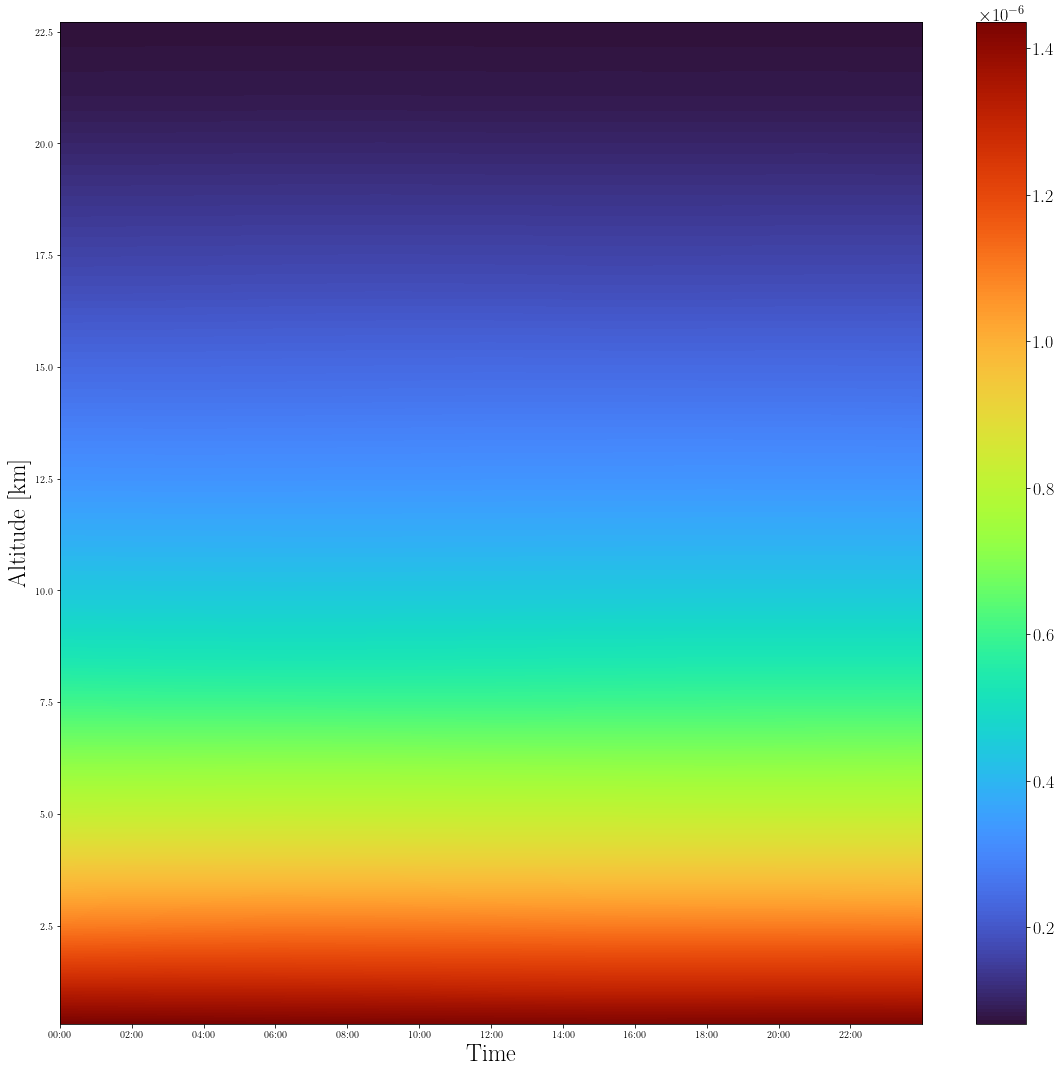

In [9]:
cur_df= mol_df
x_lims = mdates.date2num([cur_df.columns[0],cur_df.columns[-1]])
y_lims = [cur_df.index[0]*1E-3, cur_df.index[-1]*1E-3]
extent = [x_lims[0],x_lims[1],y_lims[0],y_lims[1] ]
fig, ax = plt.subplots(figsize=(16,15))
im = ax.imshow(cur_df, origin='lower',aspect='auto',cmap = 'turbo',
               extent=extent)#[0,2779,interp_sigma_df.index[0], interp_sigma_df.index[-1]])

ax.set_ylabel('Altitude [km]',fontsize = 24)
ax.set_xlabel('Time',fontsize = 24)
plt.rc('xtick',labelsize = 18)
plt.rc('ytick',labelsize = 18)
fig.colorbar(im,ax= ax)
ax.xaxis_date()
ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=120))
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.tight_layout()
plt.show()

In [10]:
# TODO: mol_xr: define attributes of as station name , altitude, Height units,
# TODO: create xarray to a daily molecular profile for three channels (UV,G,IR)
# TODO: save xarray as netcd file according to day_date paths
# TODO: convert from xarray to pytorch

# TODO: validate units of height, speed of light, sigma and beta !!! (km or m)

# TODO: create table of profiles (for the data loader)

# TODO: Create samples of 30 min acording to 'profiles' times
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}

## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.



In [11]:
bsc_paths, profile_paths = prep.load_att_bsc(lidar_parent_folder, day_date)
bsc_paths
profile_paths


['H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_00_00_01_0000_0059_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_00_00_01_0134_0308_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_00_00_01_0309_0442_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_06_00_01_0905_0957_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_18_00_01_1800_1859_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_18_00_01_1900_2010_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_18_00_01_2013_2113_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1

In [2]:
start_day =  datetime(2019,4,3)
end_day = datetime(2019,4,20)
chunk_paths = prep.convert_periodic_gdas(haifa_station,start_day, end_day)



 Failed reading H:\data_haifa\DATA FROM TROPOS\GDAS\haifa\2019\04\haifa_20190417_12_32.8_35.0.gdas1. 
 Check the source file, or generate it again with ARLreader module

 Done conversion of 143 gdas files from 2019/04/03 to 2019/04/20, 1 failed.
